In [47]:
import multiprocessing
from tqdm.notebook import tqdm
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import bokeh.io
import bokeh.plotting
import biocircuits

bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
%load_ext line_profiler

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import time
from matplotlib.animation import *

Loading BokehJS ...

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


I need to construct some sort of growth model.

- Cell volume: $C_V$
- Cell volume increase amount: $\delta$
- Nutrients: $n$
- Growth rate: $g$
$$\require{mhchem}$$
$$\ce{n ->[g] C_{V}}$$

In [185]:
class Cell_Stack:
    def __init__(self):
        self.all_cells = (cell_single(),)
        self.grand_reaction_array = np.array([])
        self.update_reaction_array()
        self.ID_list = []
        self.set_ID(self.all_cells[0] ,'0')

    def set_ID(self, curr_cell, new_ID):
        curr_cell.ID += str(new_ID)
        
    def get_variables(self):
        all_variables = []
        for curr_cell in self.all_cells:
            all_variables.extend(curr_cell.get_variables())
        return all_variables
    
    def get_variables_labels(self):
        return self.all_cells.get_variables_labels()
    
    def update_variables(self, update):
        len_vars = len(self.all_cells[0].variables.values())
        for ind in range(0, len(update), len_vars):
            cell_index = int(np.floor(ind/len_vars))
            self.all_cells[cell_index].update_variables(update[ind:ind+len_vars])
            
    def save_data(self, location, time):
        with open(location, "a+") as f:
            ret_str = str(time)
            for ind in range(len(self.all_cells)):
                ret_str += "/(" + self.all_cells[ind].ID + ")" + str(self.all_cells[ind].get_variables())
            f.write(ret_str+"\n")
            
    def check_split(self):
        ind = 0
        did_split_occur = False
        while ind < len(self.all_cells):
            curr_cell = self.all_cells[ind]
            if curr_cell.variables["V"] > 100:
                out = curr_cell.split_cell()
                self.all_cells[ind].set_variables(out[0,:])
                self.all_cells = self.all_cells[:ind] + (cell_single(),) + self.all_cells[ind:]
                self.all_cells[ind].set_variables(out[1,:])
                self.set_ID(self.all_cells[ind], self.all_cells[ind+1].ID + '0')
                self.set_ID(self.all_cells[ind+1], '1')
                ind = -1
                did_split_occur = True
            ind += 1
        return did_split_occur
                
    def get_stack_propensities(self):
        propensities = np.array([])
        for curr_cell in self.all_cells:
            propensities = np.concatenate((propensities, curr_cell.get_propensities()))
        return propensities
        
    def update_reaction_array(self):
        self.grand_reaction_array = self.all_cells[0].reaction_array
        [r_y, r_x] = np.shape(self.grand_reaction_array)
        cra_y, cra_x = 0, 0
        for curr_cell in self.all_cells[1:]:
            cra_y += r_y
            cra_x += r_x
            self.grand_reaction_array = np.concatenate((np.concatenate((self.grand_reaction_array, np.zeros([cra_y, r_x])), axis=1), np.concatenate((np.zeros([r_y, cra_x]), curr_cell.reaction_array), axis=1)))
    
class cell_single:
    def __init__(self):
        self.variables = {
            "V" : 50,
            "n_i" : 5000,
        }
        self.rates = {
            "g" : 0.05
        }
        
        self.ID = ''
        
        #                               V, n_i
        self.reaction_array = np.array([[1, -1], # R1: Consuption of n_i to make V
                                       ], dtype = int)
        
    def get_propensities(self):
#         print(self.variables["n_i"])
#         print(self.rates["g"])
        return np.array([self.variables["n_i"] * self.rates["g"], # R1: Consuption of n_i to make V
                                     ])
    def get_variables(self):
        return list(self.variables.values())
    
    def get_variables_labels(self):
        return list(self.variables.keys())
    
    def set_variables(self, new_variables):
        for ind, curr_key in enumerate(self.variables.keys()):
            self.variables.update({curr_key : new_variables[ind]})
            
    def update_variables(self, update_variables):
        for ind, curr_key in enumerate(self.variables.keys()):
            self.variables.update({curr_key : self.variables[curr_key] + update_variables[ind]})
    
    def split_cell(self):
        out = np.zeros([2, len(self.variables)])
        for ind, key in enumerate(self.variables.keys()):
            r = np.random.uniform(0.25, 0.75)
            out[0, ind] = int(round(r*self.variables[key]))
            out[1, ind] = int(round((1-r)*self.variables[key]))
        return out
    
        

In [186]:
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1
def gillespie_draw(propensities):
#     print("propensities=",propensities)
    # 2) Sum propensities
    propensity_sum = propensities.sum()
    
    # 3) Compute next time
    dt = np.random.exponential(1.0 / propensity_sum)
    
    # 4) Compute reaction probabilites from propensities
    reaction_probabilites = propensities / propensity_sum
    
    # 5) Draw a random reaction
    chosen_reaction = sample_discrete(reaction_probabilites)
    
    return chosen_reaction, dt

In [188]:
CS_obj = Cell_Stack()

time_points = np.linspace(0, 200, 2000)
# pop_out = np.empty((len(time_points), CS_obj.grand_reaction_array.shape[1]), dtype = int)

# Initialise and perform simulation
index = 0
time_index = 1
time = time_points[0]
# variables = CS_obj.get_variables()
# pop_out[0,:] = variables
propensities = np.zeros(CS_obj.grand_reaction_array.shape[1])
while index < len(time_points):
    while time < time_points[time_index]:
        # Draw reaction and time step
#         print(CS_obj.get_stack_propensities())
        reaction, dt = gillespie_draw(CS_obj.get_stack_propensities())
#         print(reaction)
        # Update variables
#         variables_previous = CS_obj.get_variables()
#         print(CS_obj.grand_reaction_array[reaction, :])
        CS_obj.update_variables(CS_obj.grand_reaction_array[reaction, :])
        
        
        
        # Increment time
        time += dt
        

    # Update index
    index = np.searchsorted(time_points > time, True)

    # Update the variables
    CS_obj.save_data("SimData\Trial1\data.txt", time)
#     pop_out[time_index:min(index, len(time_points))] = variables_previous

    # Increment index
    time_index = index
    
    CS_obj.check_split()
    CS_obj.update_reaction_array()
#     pop_out = np.concatenate((pop_out, np.zeros([np.shape(pop_out)[0], np.shape(CS_obj.get_variables())[0]-np.shape(pop_out)[1]])), axis = 1)
    

<ipython-input-186-e6a880ffe5a2>:19: RuntimeWarning: divide by zero encountered in double_scalars
  dt = np.random.exponential(1.0 / propensity_sum)
<ipython-input-186-e6a880ffe5a2>:22: RuntimeWarning: invalid value encountered in true_divide
  reaction_probabilites = propensities / propensity_sum


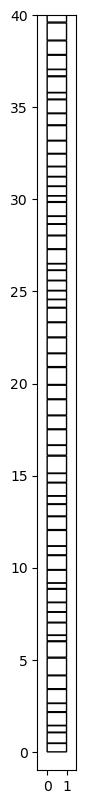

In [194]:
fig = plt.figure(figsize = (0.5,10))
ax = plt.gca()
fig.set_dpi(100)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-1,40)

with open("SimData\Trial1\data.txt", "r") as f:
    text_raw = f.read()    
text_split_raw = text_raw.split("\n")
time_axis = np.array([])

cell_Boxes = {"0" : FancyBboxPatch((0,0), 1, 50/100, boxstyle = 'round', facecolor = [1,1,1], edgecolor = [0,0,0], animated = True, mutation_scale = 0)}

def anim_init():
    ax.add_patch(cell_Boxes["0"])

def anim_update(frame_number):
    temp_curr = text_split_raw[frame_number].split("/")[1:]
    height_total = 0
    for cell_curr in temp_curr:
        
        id_curr = cell_curr.split(")")[0][1:]
#         print(id_curr)
        cell_volume = cell_curr.split("[")[1].split(",")[0]
        height_new = float(cell_volume)/100
        
        if id_curr in cell_Boxes.keys():
#             print("updated old cell")
            cell_Boxes[id_curr].set_y(height_total)
            cell_Boxes[id_curr].set_height(height_new*0.95)
        elif id_curr in [temp_itr + '0' for temp_itr in cell_Boxes.keys()]:
#             print("updated old cell plus new name")
            cell_Boxes[id_curr[:-1]].remove()
            cell_Boxes[id_curr] = cell_Boxes.pop(id_curr[:-1])
            cell_Boxes[id_curr].set_y(height_total)
            cell_Boxes[id_curr].set_height(height_new*0.95)
            ax.add_patch(cell_Boxes[id_curr])
        else:
#             print("added new cell")
            cell_Boxes[id_curr] = FancyBboxPatch((0,height_total), 1, height_new*0.95, boxstyle = 'round', facecolor = [1,1,1], edgecolor = [0,0,0], animated = True, mutation_scale = 0)
            ax.add_patch(cell_Boxes[id_curr])
        
        height_total += height_new
    return cell_Boxes
animation = FuncAnimation(fig, anim_update, frames = range(0,len(text_split_raw)), init_func = anim_init, interval = 100)
animation.save('SimData/Trial1/animation1.mp4', fps=30, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])

In [169]:
text_split_raw

['1.056046462781489/(0)[97, 453]',
 '2.112587956497381/(0)[138, 412]',
 '3.164339606826823/(00)[77.0, 261.0]/(01)[96.0, 116.0]',
 '4.220229120265125/(00)[105.0, 233.0]/(01)[104.0, 108.0]',
 '5.300451842030021/(000)[46.0, 59.0]/(001)[79.0, 154.0]/(010)[52.0, 51.0]/(011)[65.0, 44.0]',
 '6.318334005847849/(000)[50.0, 55.0]/(001)[97.0, 136.0]/(010)[56.0, 47.0]/(011)[67.0, 42.0]',
 '7.400170303447702/(000)[58.0, 47.0]/(001)[109.0, 124.0]/(010)[66.0, 37.0]/(011)[73.0, 36.0]',
 '8.441987946562175/(000)[65.0, 40.0]/(0010)[55.0, 52.0]/(0011)[73.0, 53.0]/(010)[68.0, 35.0]/(011)[75.0, 34.0]',
 '9.485693029336545/(000)[70.0, 35.0]/(0010)[61.0, 46.0]/(0011)[77.0, 49.0]/(010)[71.0, 32.0]/(011)[77.0, 32.0]',
 '10.59053421466965/(000)[73.0, 32.0]/(0010)[66.0, 41.0]/(0011)[81.0, 45.0]/(010)[74.0, 29.0]/(011)[80.0, 29.0]',
 '11.623500259387594/(000)[75.0, 30.0]/(0010)[68.0, 39.0]/(0011)[87.0, 39.0]/(010)[79.0, 24.0]/(011)[83.0, 26.0]',
 '12.66704027138693/(000)[77.0, 28.0]/(0010)[71.0, 36.0]/(0011)[90.0

In [66]:
text_split_raw[2].split("/")[1:][0].split("[")[1].split(",")[0]

'77.0'

In [58]:
cell_Boxes = {"00" : FancyBboxPatch((0,0), 1, 50/100, boxstyle = 'round', facecolor = [0,0,0], edgecolor = [0,0,0], animated = True)}

In [59]:
if id_curr in cell_Boxes.keys():
    print(1)

1


In [93]:
list(cell_Boxes.keys()) + '0'

TypeError: can only concatenate list (not "str") to list

In [153]:
[temp_itr + '0' for temp_itr in cell_Boxes.keys()]

['0000', '0100', '0110', '00100', '001100', '001110', '000', '010']

In [159]:
out_split = list(out.split("\n"))

In [160]:
out_split[0]

'/1.065330467786004,0,[101, 449]/'

In [57]:
[curr_cell.ID for curr_cell in CS_obj.all_cells]

['0000', '0001', '001', '0100', '0101', '0110', '01110', '01111']

In [928]:
'0' -> '00' + '01'

['0', '0']

In [978]:
pop_out

array([[ 50., 500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [109., 441.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 94., 180.,  56., 220.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [111., 163.,  82., 194.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 80.,  62.,  43.,  89., 107., 169.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 88.,  54.,  56.,  76.,  59.,  51.,  64., 102.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 94.,  48.,  61.,  71.,  63.,  47.,  75.,  91.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 98.,  44.,  72.,  60.,  66.,  44.,  84.,  82.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [104.,  38.,  78.,  54.,  71.,  39.,  90.,  76.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [ 45.,  12.,  64.,  21.,  84.,  48.,  75.,  35.,  95.,  71.,   0.,
          0.,   0

In [795]:
a = np.ones([1,3])
print(a)

[[1. 1. 1.]]


In [960]:
ind = 1
a = (1,2)
a[:ind] + (9,) + a[ind:]

(1, 9, 2)

In [801]:
pop_out

array([[ 50, 500],
       [ 99, 451],
       [144, 406],
       [185, 365],
       [225, 325],
       [253, 297],
       [291, 259],
       [316, 234],
       [342, 208],
       [360, 190]])

In [806]:
CS_obj.check_split()
np.shape(CS_obj.get_variables())

(10,)

In [816]:
np.concatenate((pop_out, np.zeros([np.shape(pop_out)[0], np.shape(CS_obj.get_variables())[0]-np.shape(pop_out)[1]])), axis = 1)

array([[ 50., 500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 99., 451.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [144., 406.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [185., 365.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [225., 325.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [253., 297.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [291., 259.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [316., 234.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [342., 208.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [360., 190.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [810]:
np.shape(pop_out)[0]

10

In [812]:
np.shape(CS_obj.get_variables())[0]

10

In [881]:
a = str(1)

In [882]:
print(a)

1


<_io.TextIOWrapper name='SimData/temp.text' mode='w+' encoding='cp1252'>

In [17]:
f.close

<function TextIOWrapper.close()>

In [18]:
CS_obj = Cell_Stack()

In [19]:
time = 1.234

In [36]:
CS_obj.get_variables()

[96.0,
 25.0,
 67.0,
 9.0,
 75.0,
 16.0,
 36.0,
 11.0,
 58.0,
 12.0,
 52.0,
 7.0,
 76.0,
 10.0]

In [51]:
ret_str = [time]
for ind in range(len(CS_obj.all_cells)):
    ret_str += [[CS_obj.all_cells[ind].ID], [CS_obj.all_cells[ind].get_variables()]]

In [24]:
str([time] + CS_obj.get_variables())

'[1.234, 50, 500]'

In [41]:
CS_obj.all_cells[1].get_variables()

[67.0, 9.0]

In [43]:
ret_str = [time]

In [45]:
ret_str + [

[20.04253601765396, 1]

In [46]:
[CS_obj.all_cells[ind].ID]

['000']

In [47]:
[CS_obj.all_cells[ind].get_variables()]

[[96.0, 25.0]]

In [52]:
ret_str

[20.04253601765396,
 ['000'],
 [[96.0, 25.0]],
 ['001'],
 [[67.0, 9.0]],
 ['0100'],
 [[75.0, 16.0]],
 ['0101'],
 [[36.0, 11.0]],
 ['01100'],
 [[58.0, 12.0]],
 ['01101'],
 [[52.0, 7.0]],
 ['0111'],
 [[76.0, 10.0]]]